In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

In [4]:
train_dir = '/home/takayuki/Desktop/sem6/DL/dl_lab/data/cats_and_dogs_filtered/train'
test_dir = '/home/takayuki/Desktop/sem6/DL/dl_lab/data/cats_and_dogs_filtered/validation'

mytf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.ImageFolder(train_dir, transform=mytf)
test_data = datasets.ImageFolder(test_dir, transform=mytf)

batchSize = 8

train_loader = DataLoader(train_data, batchSize, shuffle=True)
test_loader = DataLoader(test_data, batchSize, shuffle=False)

In [ ]:
# Intialize the model with or without dropout

class CNN(nn.Module):
    def __init__(self, use_dropout=False):
        super(CNN, self).__init__()

        self.use_dropout = use_dropout
        dropout_layer = nn.Dropout(0.3) if use_dropout else nn.Identity()

        self.net = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.ReLU(),
            dropout_layer,
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            dropout_layer,
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            dropout_layer,
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            dropout_layer,
            nn.MaxPool2d(2, 2),

            nn.Flatten()
        )

        feature_size = self.get_dims()

        self.classification = nn.Sequential(
            nn.Linear(feature_size, 100),
            nn.ReLU(),
            dropout_layer,

            nn.Linear(100, 50),
            nn.ReLU(),
            dropout_layer,

            nn.Linear(50, 2)
        )

    def forward(self, x):
        fs = self.net(x)
        return self.classification(fs)
    
    def get_dims(self):
        dummy = torch.randn(1, 3, 224, 224)
        y = self.net(dummy)
        return y.numel()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

model = CNN(use_dropout=False).to(device)
model2 = CNN(use_dropout=True).to(device)

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00005)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.00005)

In [ ]:
epochs = 30

loss_list = []
val_loss_list = []
accuracy_list = []
val_acc_list = []

loss_list_2 = []
val_loss_list_2 = []
accuracy_list_2 = []
val_acc_list_2 = []


def count_correct(out, lab):
    return sum(out.argmax(1) == lab).item()

for ep in range(epochs):
    
    model.train()
    model2.train()
    
    rloss = 0
    corr = 0
    
    rloss2 = 0
    corr2 = 0
    
    for inp, lab in train_loader:
        inp, lab = inp.to(device), lab.to(device)

        out = model(inp)
        loss = criteria(out, lab)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        rloss += loss
        corr += count_correct(out, lab)
        
        #model2
        
        out2 = model2(inp)
        loss2 = criteria(out2, lab)
        
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

        rloss2 += loss2
        corr2 += count_correct(out2, lab)
    
    tloss = rloss / len(train_loader)
    tacc = 100 * (corr / (len(train_loader) * batchSize))
    loss_list.append(tloss.item())
    accuracy_list.append(tacc)
    
    # model 2
    
    tloss2 = rloss2 / len(train_loader)
    tacc2 = 100 * (corr2 / (len(train_loader) * batchSize))
    loss_list_2.append(tloss2.item())
    accuracy_list_2.append(tacc2)

    model.eval()
    
    rloss = 0
    corr = 0
    
    rloss2 = 0
    corr2 = 0

    for inp, lab in test_loader:
        inp, lab = inp.to(device), lab.to(device)
        
        with torch.no_grad():
            out = model(inp)
            out2 = model2(inp)
        
        rloss += criteria(out, lab)
        corr += count_correct(out, lab)
        
        rloss2 += criteria(out2, lab)
        corr2 += count_correct(out2, lab)
    
    vloss = rloss / len(test_loader)
    vacc = 100 * (corr / (len(test_loader) * batchSize))
    val_loss_list.append(vloss.item())
    val_acc_list.append(vacc)
    
    # model 2
    vloss2 = rloss2 / len(test_loader)
    vacc2 = 100 * (corr2 / (len(test_loader) * batchSize))
    val_loss_list_2.append(vloss2.item())
    val_acc_list_2.append(vacc2)

    print(f"Model 1: Ep {ep+1}/{epochs}: TrainLoss = {tloss:.4f}, ValLoss = {vloss:.4f}, TrainAcc = {tacc:.2f}%, ValAcc = {vacc:.2f}%")
    print(f"Model 2: Ep {ep+1}/{epochs}: TrainLoss = {tloss2:.4f}, ValLoss = {vloss2:.4f}, TrainAcc = {tacc2:.2f}%, ValAcc = {vacc2:.2f}%")
    

Model 1: Ep 1/20: TrainLoss = 0.6938, ValLoss = 0.6912, TrainAcc = 50.40%, ValAcc = 53.60%
Model 2: Ep 1/20: TrainLoss = 0.6949, ValLoss = 0.6948, TrainAcc = 49.90%, ValAcc = 47.60%
Model 1: Ep 2/20: TrainLoss = 0.6888, ValLoss = 0.6867, TrainAcc = 54.20%, ValAcc = 55.20%
Model 2: Ep 2/20: TrainLoss = 0.6941, ValLoss = 0.6939, TrainAcc = 49.90%, ValAcc = 51.30%
Model 1: Ep 3/20: TrainLoss = 0.6772, ValLoss = 0.6668, TrainAcc = 57.05%, ValAcc = 64.10%
Model 2: Ep 3/20: TrainLoss = 0.6936, ValLoss = 0.6941, TrainAcc = 49.75%, ValAcc = 49.80%
Model 1: Ep 4/20: TrainLoss = 0.6627, ValLoss = 0.6486, TrainAcc = 60.25%, ValAcc = 65.60%
Model 2: Ep 4/20: TrainLoss = 0.6918, ValLoss = 0.6914, TrainAcc = 52.25%, ValAcc = 51.60%
Model 1: Ep 5/20: TrainLoss = 0.6442, ValLoss = 0.6340, TrainAcc = 63.70%, ValAcc = 64.50%
Model 2: Ep 5/20: TrainLoss = 0.6901, ValLoss = 0.6918, TrainAcc = 54.00%, ValAcc = 52.00%
Model 1: Ep 6/20: TrainLoss = 0.6324, ValLoss = 0.6263, TrainAcc = 64.65%, ValAcc = 66.50%

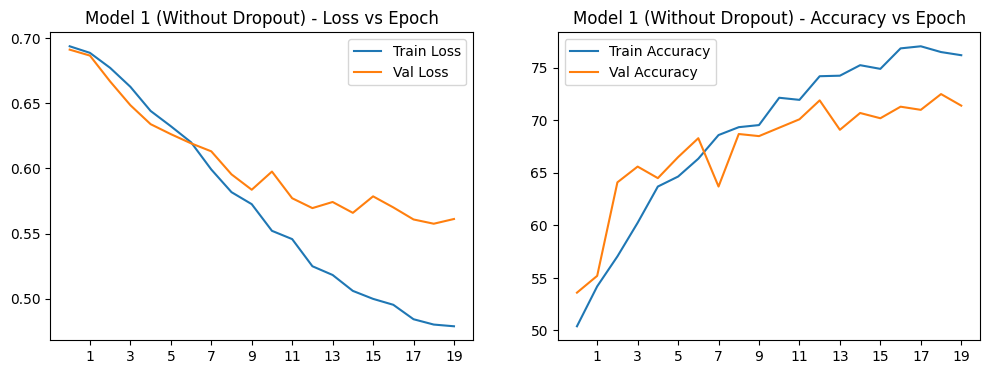

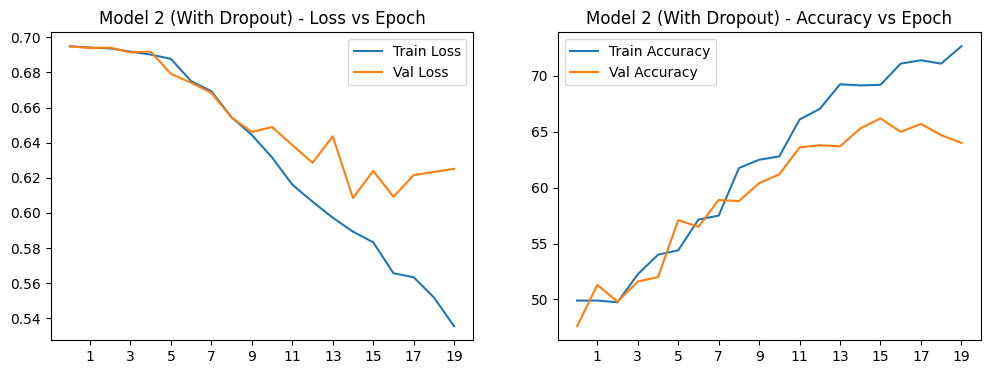

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Model 1 (Without Dropout) - Loss vs Epoch")
plt.plot(loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xticks(range(1, epochs+1, 2))
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Model 1 (Without Dropout) - Accuracy vs Epoch")
plt.plot(accuracy_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xticks(range(1, epochs+1, 2))
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Model 2 (With Dropout) - Loss vs Epoch")
plt.plot(loss_list_2, label='Train Loss')
plt.plot(val_loss_list_2, label='Val Loss') 
plt.xticks(range(1, epochs+1, 2))
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Model 2 (With Dropout) - Accuracy vs Epoch")
plt.plot(accuracy_list_2, label='Train Accuracy')
plt.plot(val_acc_list_2, label='Val Accuracy')
plt.xticks(range(1, epochs+1, 2))
plt.legend()
plt.show()

In [15]:
print("Final Training and Validation Accuracies - ")
print(f"Without Dropout:\t TrainAcc = {accuracy_list[-1]:.2f}%, ValAcc = {val_acc_list[-1]:.2f}%")
print(f"With the Dropout:\t TrainAcc = {accuracy_list_2[-1]:.2f}%, ValAcc = {val_acc_list_2[-1]:.2f}%")

print("\nFinal Training and Validation Losses - ")
print(f"Without Dropout:\t TrainLoss = {loss_list[-1]:.4f}, ValLoss = {val_loss_list[-1]:.4f}")
print(f"With the Dropout:\t TrainLoss = {loss_list_2[-1]:.4f}, ValLoss = {val_loss_list_2[-1]:.4f}")

Final Training and Validation Accuracies - 
Without Dropout:	 TrainAcc = 76.20%, ValAcc = 71.40%
With the Dropout:	 TrainAcc = 72.65%, ValAcc = 64.00%

Final Training and Validation Losses - 
Without Dropout:	 TrainLoss = 0.4788, ValLoss = 0.5612
With the Dropout:	 TrainLoss = 0.5355, ValLoss = 0.6251
